# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
#for i in range(1, 6):                                      # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#        dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
#        if np.any(dones):                                  # exit loop if episode finished
#            break
#    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

Multi agent DDPG algorithm from [Lowe et. al. MADDPG paper](https://arxiv.org/abs/1706.02275) <br>
Some ideas and inspiration taken from Amit Patel. ([Blog](https://medium.com/@amitpatel.gt/maddpg-91caa221d75e) and [GitHub repo](https://github.com/gtg162y/DRLND/tree/master/P3_Collab_Compete))

In [7]:
from datetime import datetime
import math

#temporary
#import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import copy
import random
import pickle
from models import *
import os

In [8]:
from models import *
#this contains actor_network and critic_network classes
#ddpg_Agent is a class for a single agent. It depends on num_agents as this dictates input size to critic

from agent import *
#contains ddpg_Agent and replay buffer classes. Also a noise generation function


In [9]:
HIDDEN1_SIZE = 256
HIDDEN2_SIZE = 128

#Ornstein-Uhlenbeck Noise - not used
OU_THETA = 0.15
OU_SIGMA = 0.1 

GAUSSIAN_MEAN = 0
GAUSSIAN_STDEV = 0.5

#Decay amplitude of noise
NOISE_START = 1.0
NOISE_DECAY = 0.999
NOISE_END = 0.1
print('Takes %s decays for noise to reach %s'% (math.log((NOISE_END/NOISE_START),NOISE_DECAY), NOISE_END) )

REPLAY_MAX_SIZE = 1e5#1e6
BATCH_SIZE = 256

GAMMA=0.99
CRITIC_LR = 3e-4
ACTOR_LR = 1e-4
TAU = 1e-3


N_RANDOM = 300 #500
UPDATES_PER_STEP = 3

checkpoint_dir = "./checkpoints"
run_name = datetime.now().strftime('%Y%m%d_%H%M')
print('Run name = ',run_name)
SAVE_EVERY = 100

NUM_EPISODES = 2500

batch_norm = False#True

Takes 2301.4336084694537 decays for noise to reach 0.1
Run name =  20200612_1838


In [10]:
def timedelta_to_str(d):
    '''function to format a timedelta string nicely'''
    s = d.seconds
    h = math.floor(s/3600)
    m = math.floor((s-h*3600)/60)
    return('%sh %sm'%(h,m))

In [11]:
#train

maddpg = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents, 
                hidden1_size=HIDDEN1_SIZE, hidden2_size=HIDDEN2_SIZE, 
                max_replay_size=REPLAY_MAX_SIZE, batch_size=BATCH_SIZE,
                actor_lr=ACTOR_LR, critic_lr=CRITIC_LR, 
                gamma=GAMMA, tau=TAU, batch_norm=batch_norm)


score_history = []
action_history = [] #no noise
noise_history = []

start_time = datetime.now()

maddpg.learn_in_step = False #At start do not perform learn step (weights update), only add to replay memory
ep = NOISE_START
for episode in range(NUM_EPISODES):                                      
    env_info = env.reset(train_mode=True)[brain_name]       
    states = env_info.vector_observations                  
    #shape (2,24), (num_agents,state_size)
    scores = np.zeros(num_agents)   
    noise_generator = gaussian_noise(action_size = action_size, num_agents = num_agents, mean =GAUSSIAN_MEAN, stdev=GAUSSIAN_STDEV)

    if episode<N_RANDOM: 
        rand=True
        maddpg.learn_in_step = False
    else:
        rand=False
        maddpg.learn_in_step = True
        ep = max(ep*NOISE_DECAY,NOISE_END)
    while True:
        if rand:
            actions  = np.random.randn(num_agents, action_size)
            actions = np.clip(actions, -1, 1)
        else:
            actions = maddpg.get_actions(states) # use actors to select action for each agent.size (num_agents, action_size)
            action_history.append(actions)
            noise = ep * noise_generator.get_noise() #add noise
            noise_history.append(noise)
            actions = np.clip(actions+noise, -1, 1)
        
        env_info = env.step(actions)[brain_name]  
        
        next_states = env_info.vector_observations         
        #print(next_states.shape)
        rewards = env_info.rewards #list of length num_agents
        dones = env_info.local_done #list of length num_agents 
        
        maddpg.step(states,actions,rewards,next_states,dones,UPDATES_PER_STEP)
        
        scores += env_info.rewards 
        states = next_states
        if np.any(dones):                                  
            break
    #print('Score (max over agents) from episode {}: {}'.format(episode, np.max(scores)))
    
    score_history.append(np.max(scores))
    now_time = datetime.now()
    run_time = now_time-start_time
    forecast_time = (run_time / (episode + 1)) * (NUM_EPISODES - episode - 1)
    print('episode = %s, score = %.3f, ep = %.3f running for: %s, time to go: %s'%(episode+1,np.max(scores),ep,
                                                                    timedelta_to_str(run_time),
                                                                    timedelta_to_str(forecast_time)))

    
    if episode%SAVE_EVERY==0 and episode!=0:
        maddpg.checkpoint(run_name, checkpoint_dir, episode, scores = score_history)
        print('checkpoint saved ep',episode)
        print('step count = ',maddpg.learn_step_count)
#Score (max over agents) from episode 1: 0.0

episode = 1, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 2m
episode = 2, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 6m
episode = 3, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 4m
episode = 4, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 4m
episode = 5, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 3m
episode = 6, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 3m
episode = 7, score = 0.100, ep = 1.000 running for: 0h 0m, time to go: 0h 3m
episode = 8, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 3m
episode = 9, score = 0.090, ep = 1.000 running for: 0h 0m, time to go: 0h 3m
episode = 10, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 2m
episode = 11, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 2m
episode = 12, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 2m
episode = 13, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0

episode = 106, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 107, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 108, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 109, score = 0.100, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 110, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 111, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 112, score = 0.200, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 113, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 114, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 115, score = 0.090, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 116, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 117, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 118, score = 0.100, ep = 1.000 running for

episode = 211, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 212, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 213, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 214, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 215, score = 0.090, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 216, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 217, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 218, score = 0.100, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 219, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 220, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 221, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 222, score = 0.000, ep = 1.000 running for: 0h 0m, time to go: 0h 1m
episode = 223, score = 0.000, ep = 1.000 running for

episode = 315, score = 0.000, ep = 0.985 running for: 0h 0m, time to go: 0h 6m
episode = 316, score = 0.000, ep = 0.984 running for: 0h 0m, time to go: 0h 6m
episode = 317, score = 0.000, ep = 0.983 running for: 0h 1m, time to go: 0h 7m
episode = 318, score = 0.000, ep = 0.982 running for: 0h 1m, time to go: 0h 7m
episode = 319, score = 0.000, ep = 0.981 running for: 0h 1m, time to go: 0h 7m
episode = 320, score = 0.000, ep = 0.980 running for: 0h 1m, time to go: 0h 7m
episode = 321, score = 0.000, ep = 0.979 running for: 0h 1m, time to go: 0h 8m
episode = 322, score = 0.000, ep = 0.978 running for: 0h 1m, time to go: 0h 8m
episode = 323, score = 0.000, ep = 0.977 running for: 0h 1m, time to go: 0h 8m
episode = 324, score = 0.100, ep = 0.976 running for: 0h 1m, time to go: 0h 9m
episode = 325, score = 0.000, ep = 0.975 running for: 0h 1m, time to go: 0h 9m
episode = 326, score = 0.000, ep = 0.974 running for: 0h 1m, time to go: 0h 9m
episode = 327, score = 0.000, ep = 0.973 running for

episode = 418, score = 0.000, ep = 0.889 running for: 0h 4m, time to go: 0h 24m
episode = 419, score = 0.000, ep = 0.888 running for: 0h 4m, time to go: 0h 24m
episode = 420, score = 0.000, ep = 0.887 running for: 0h 5m, time to go: 0h 24m
episode = 421, score = 0.000, ep = 0.886 running for: 0h 5m, time to go: 0h 24m
episode = 422, score = 0.000, ep = 0.885 running for: 0h 5m, time to go: 0h 25m
episode = 423, score = 0.000, ep = 0.884 running for: 0h 5m, time to go: 0h 25m
episode = 424, score = 0.000, ep = 0.883 running for: 0h 5m, time to go: 0h 25m
episode = 425, score = 0.000, ep = 0.882 running for: 0h 5m, time to go: 0h 25m
episode = 426, score = 0.000, ep = 0.882 running for: 0h 5m, time to go: 0h 25m
episode = 427, score = 0.000, ep = 0.881 running for: 0h 5m, time to go: 0h 25m
episode = 428, score = 0.000, ep = 0.880 running for: 0h 5m, time to go: 0h 25m
episode = 429, score = 0.000, ep = 0.879 running for: 0h 5m, time to go: 0h 25m
episode = 430, score = 0.000, ep = 0.878

episode = 520, score = 0.000, ep = 0.802 running for: 0h 9m, time to go: 0h 34m
episode = 521, score = 0.000, ep = 0.802 running for: 0h 9m, time to go: 0h 34m
episode = 522, score = 0.000, ep = 0.801 running for: 0h 9m, time to go: 0h 34m
episode = 523, score = 0.000, ep = 0.800 running for: 0h 9m, time to go: 0h 35m
episode = 524, score = 0.000, ep = 0.799 running for: 0h 9m, time to go: 0h 35m
episode = 525, score = 0.000, ep = 0.798 running for: 0h 9m, time to go: 0h 35m
episode = 526, score = 0.000, ep = 0.798 running for: 0h 9m, time to go: 0h 35m
episode = 527, score = 0.000, ep = 0.797 running for: 0h 9m, time to go: 0h 35m
episode = 528, score = 0.000, ep = 0.796 running for: 0h 9m, time to go: 0h 35m
episode = 529, score = 0.000, ep = 0.795 running for: 0h 9m, time to go: 0h 35m
episode = 530, score = 0.000, ep = 0.794 running for: 0h 9m, time to go: 0h 35m
episode = 531, score = 0.000, ep = 0.794 running for: 0h 9m, time to go: 0h 35m
episode = 532, score = 0.000, ep = 0.793

episode = 621, score = 0.090, ep = 0.725 running for: 0h 13m, time to go: 0h 40m
episode = 622, score = 0.090, ep = 0.725 running for: 0h 13m, time to go: 0h 40m
episode = 623, score = 0.100, ep = 0.724 running for: 0h 13m, time to go: 0h 40m
episode = 624, score = 0.000, ep = 0.723 running for: 0h 13m, time to go: 0h 40m
episode = 625, score = 0.000, ep = 0.722 running for: 0h 13m, time to go: 0h 40m
episode = 626, score = 0.000, ep = 0.722 running for: 0h 13m, time to go: 0h 40m
episode = 627, score = 0.000, ep = 0.721 running for: 0h 13m, time to go: 0h 40m
episode = 628, score = 0.000, ep = 0.720 running for: 0h 13m, time to go: 0h 40m
episode = 629, score = 0.000, ep = 0.720 running for: 0h 13m, time to go: 0h 40m
episode = 630, score = 0.000, ep = 0.719 running for: 0h 13m, time to go: 0h 40m
episode = 631, score = 0.000, ep = 0.718 running for: 0h 13m, time to go: 0h 40m
episode = 632, score = 0.000, ep = 0.717 running for: 0h 13m, time to go: 0h 40m
episode = 633, score = 0.000

episode = 722, score = 0.100, ep = 0.656 running for: 0h 20m, time to go: 0h 50m
episode = 723, score = 0.000, ep = 0.655 running for: 0h 20m, time to go: 0h 50m
episode = 724, score = 0.100, ep = 0.654 running for: 0h 20m, time to go: 0h 51m
episode = 725, score = 0.090, ep = 0.654 running for: 0h 21m, time to go: 0h 51m
episode = 726, score = 0.090, ep = 0.653 running for: 0h 21m, time to go: 0h 51m
episode = 727, score = 0.000, ep = 0.652 running for: 0h 21m, time to go: 0h 51m
episode = 728, score = 0.100, ep = 0.652 running for: 0h 21m, time to go: 0h 51m
episode = 729, score = 0.300, ep = 0.651 running for: 0h 21m, time to go: 0h 53m
episode = 730, score = 0.100, ep = 0.650 running for: 0h 21m, time to go: 0h 53m
episode = 731, score = 0.100, ep = 0.650 running for: 0h 22m, time to go: 0h 53m
episode = 732, score = 0.200, ep = 0.649 running for: 0h 22m, time to go: 0h 54m
episode = 733, score = 0.100, ep = 0.648 running for: 0h 22m, time to go: 0h 54m
episode = 734, score = 0.090

episode = 824, score = 0.100, ep = 0.592 running for: 0h 34m, time to go: 1h 10m
episode = 825, score = 0.100, ep = 0.591 running for: 0h 35m, time to go: 1h 11m
episode = 826, score = 0.000, ep = 0.591 running for: 0h 35m, time to go: 1h 11m
episode = 827, score = 0.090, ep = 0.590 running for: 0h 35m, time to go: 1h 11m
episode = 828, score = 0.100, ep = 0.590 running for: 0h 35m, time to go: 1h 11m
episode = 829, score = 0.100, ep = 0.589 running for: 0h 35m, time to go: 1h 11m
episode = 830, score = 0.100, ep = 0.588 running for: 0h 35m, time to go: 1h 11m
episode = 831, score = 0.090, ep = 0.588 running for: 0h 35m, time to go: 1h 11m
episode = 832, score = 0.100, ep = 0.587 running for: 0h 35m, time to go: 1h 11m
episode = 833, score = 0.090, ep = 0.587 running for: 0h 36m, time to go: 1h 12m
episode = 834, score = 0.100, ep = 0.586 running for: 0h 36m, time to go: 1h 12m
episode = 835, score = 0.100, ep = 0.586 running for: 0h 36m, time to go: 1h 12m
episode = 836, score = 0.090

episode = 925, score = 0.100, ep = 0.535 running for: 0h 48m, time to go: 1h 22m
episode = 926, score = 0.100, ep = 0.535 running for: 0h 48m, time to go: 1h 22m
episode = 927, score = 0.000, ep = 0.534 running for: 0h 48m, time to go: 1h 22m
episode = 928, score = 0.100, ep = 0.533 running for: 0h 48m, time to go: 1h 22m
episode = 929, score = 0.100, ep = 0.533 running for: 0h 48m, time to go: 1h 22m
episode = 930, score = 0.100, ep = 0.532 running for: 0h 48m, time to go: 1h 22m
episode = 931, score = 0.100, ep = 0.532 running for: 0h 48m, time to go: 1h 22m
episode = 932, score = 0.100, ep = 0.531 running for: 0h 48m, time to go: 1h 22m
episode = 933, score = 0.200, ep = 0.531 running for: 0h 49m, time to go: 1h 22m
episode = 934, score = 0.090, ep = 0.530 running for: 0h 49m, time to go: 1h 22m
episode = 935, score = 0.100, ep = 0.530 running for: 0h 49m, time to go: 1h 22m
episode = 936, score = 0.100, ep = 0.529 running for: 0h 49m, time to go: 1h 22m
episode = 937, score = 0.100

episode = 1026, score = 0.000, ep = 0.484 running for: 0h 58m, time to go: 1h 23m
episode = 1027, score = 0.090, ep = 0.483 running for: 0h 58m, time to go: 1h 23m
episode = 1028, score = 0.100, ep = 0.483 running for: 0h 58m, time to go: 1h 23m
episode = 1029, score = 0.100, ep = 0.482 running for: 0h 58m, time to go: 1h 23m
episode = 1030, score = 0.100, ep = 0.482 running for: 0h 58m, time to go: 1h 23m
episode = 1031, score = 0.100, ep = 0.481 running for: 0h 58m, time to go: 1h 23m
episode = 1032, score = 0.100, ep = 0.481 running for: 0h 58m, time to go: 1h 23m
episode = 1033, score = 0.000, ep = 0.480 running for: 0h 58m, time to go: 1h 23m
episode = 1034, score = 0.090, ep = 0.480 running for: 0h 58m, time to go: 1h 23m
episode = 1035, score = 0.100, ep = 0.479 running for: 0h 59m, time to go: 1h 23m
episode = 1036, score = 0.100, ep = 0.479 running for: 0h 59m, time to go: 1h 23m
episode = 1037, score = 0.100, ep = 0.478 running for: 0h 59m, time to go: 1h 23m
episode = 1038, 

episode = 1127, score = 0.100, ep = 0.437 running for: 1h 8m, time to go: 1h 23m
episode = 1128, score = 0.200, ep = 0.437 running for: 1h 9m, time to go: 1h 24m
episode = 1129, score = 0.100, ep = 0.436 running for: 1h 9m, time to go: 1h 24m
episode = 1130, score = 0.000, ep = 0.436 running for: 1h 9m, time to go: 1h 24m
episode = 1131, score = 0.000, ep = 0.435 running for: 1h 9m, time to go: 1h 23m
episode = 1132, score = 0.000, ep = 0.435 running for: 1h 9m, time to go: 1h 23m
episode = 1133, score = 0.100, ep = 0.435 running for: 1h 9m, time to go: 1h 23m
episode = 1134, score = 0.000, ep = 0.434 running for: 1h 9m, time to go: 1h 23m
episode = 1135, score = 0.100, ep = 0.434 running for: 1h 9m, time to go: 1h 23m
episode = 1136, score = 0.100, ep = 0.433 running for: 1h 9m, time to go: 1h 23m
episode = 1137, score = 0.100, ep = 0.433 running for: 1h 9m, time to go: 1h 23m
episode = 1138, score = 0.100, ep = 0.432 running for: 1h 9m, time to go: 1h 23m
episode = 1139, score = 0.10

episode = 1227, score = 0.100, ep = 0.396 running for: 1h 22m, time to go: 1h 25m
episode = 1228, score = 0.100, ep = 0.395 running for: 1h 22m, time to go: 1h 25m
episode = 1229, score = 0.000, ep = 0.395 running for: 1h 22m, time to go: 1h 25m
episode = 1230, score = 0.100, ep = 0.394 running for: 1h 22m, time to go: 1h 25m
episode = 1231, score = 0.090, ep = 0.394 running for: 1h 22m, time to go: 1h 25m
episode = 1232, score = 0.300, ep = 0.394 running for: 1h 23m, time to go: 1h 25m
episode = 1233, score = 0.500, ep = 0.393 running for: 1h 23m, time to go: 1h 26m
episode = 1234, score = 0.100, ep = 0.393 running for: 1h 23m, time to go: 1h 25m
episode = 1235, score = 0.090, ep = 0.392 running for: 1h 23m, time to go: 1h 25m
episode = 1236, score = 0.300, ep = 0.392 running for: 1h 24m, time to go: 1h 26m
episode = 1237, score = 0.100, ep = 0.392 running for: 1h 24m, time to go: 1h 26m
episode = 1238, score = 0.100, ep = 0.391 running for: 1h 24m, time to go: 1h 26m
episode = 1239, 

episode = 1327, score = 0.300, ep = 0.358 running for: 1h 37m, time to go: 1h 26m
episode = 1328, score = 0.100, ep = 0.358 running for: 1h 37m, time to go: 1h 26m
episode = 1329, score = 0.100, ep = 0.357 running for: 1h 37m, time to go: 1h 26m
episode = 1330, score = 0.100, ep = 0.357 running for: 1h 38m, time to go: 1h 26m
episode = 1331, score = 0.200, ep = 0.356 running for: 1h 38m, time to go: 1h 26m
episode = 1332, score = 0.100, ep = 0.356 running for: 1h 38m, time to go: 1h 26m
episode = 1333, score = 0.200, ep = 0.356 running for: 1h 38m, time to go: 1h 26m
episode = 1334, score = 0.300, ep = 0.355 running for: 1h 39m, time to go: 1h 26m
episode = 1335, score = 0.100, ep = 0.355 running for: 1h 39m, time to go: 1h 26m
episode = 1336, score = 0.100, ep = 0.355 running for: 1h 39m, time to go: 1h 26m
episode = 1337, score = 0.100, ep = 0.354 running for: 1h 39m, time to go: 1h 26m
episode = 1338, score = 0.200, ep = 0.354 running for: 1h 39m, time to go: 1h 26m
episode = 1339, 

episode = 1427, score = 0.090, ep = 0.324 running for: 1h 52m, time to go: 1h 24m
episode = 1428, score = 0.090, ep = 0.323 running for: 1h 52m, time to go: 1h 24m
episode = 1429, score = 0.090, ep = 0.323 running for: 1h 52m, time to go: 1h 24m
episode = 1430, score = 0.200, ep = 0.323 running for: 1h 52m, time to go: 1h 24m
episode = 1431, score = 0.200, ep = 0.323 running for: 1h 52m, time to go: 1h 24m
episode = 1432, score = 0.090, ep = 0.322 running for: 1h 53m, time to go: 1h 24m
episode = 1433, score = 0.100, ep = 0.322 running for: 1h 53m, time to go: 1h 24m
episode = 1434, score = 0.100, ep = 0.322 running for: 1h 53m, time to go: 1h 24m
episode = 1435, score = 0.100, ep = 0.321 running for: 1h 53m, time to go: 1h 24m
episode = 1436, score = 0.200, ep = 0.321 running for: 1h 53m, time to go: 1h 24m
episode = 1437, score = 0.090, ep = 0.321 running for: 1h 53m, time to go: 1h 24m
episode = 1438, score = 0.300, ep = 0.320 running for: 1h 54m, time to go: 1h 24m
episode = 1439, 

episode = 1528, score = 0.000, ep = 0.293 running for: 2h 8m, time to go: 1h 21m
episode = 1529, score = 0.400, ep = 0.292 running for: 2h 8m, time to go: 1h 21m
episode = 1530, score = 0.000, ep = 0.292 running for: 2h 8m, time to go: 1h 21m
episode = 1531, score = 0.400, ep = 0.292 running for: 2h 9m, time to go: 1h 21m
episode = 1532, score = 0.100, ep = 0.292 running for: 2h 9m, time to go: 1h 21m
episode = 1533, score = 0.200, ep = 0.291 running for: 2h 9m, time to go: 1h 21m
episode = 1534, score = 0.000, ep = 0.291 running for: 2h 9m, time to go: 1h 21m
episode = 1535, score = 0.100, ep = 0.291 running for: 2h 10m, time to go: 1h 21m
episode = 1536, score = 0.200, ep = 0.290 running for: 2h 10m, time to go: 1h 21m
episode = 1537, score = 0.200, ep = 0.290 running for: 2h 10m, time to go: 1h 21m
episode = 1538, score = 0.100, ep = 0.290 running for: 2h 10m, time to go: 1h 21m
episode = 1539, score = 0.000, ep = 0.289 running for: 2h 10m, time to go: 1h 21m
episode = 1540, score =

episode = 1628, score = 0.200, ep = 0.265 running for: 2h 36m, time to go: 1h 23m
episode = 1629, score = 0.700, ep = 0.265 running for: 2h 37m, time to go: 1h 24m
episode = 1630, score = 0.100, ep = 0.264 running for: 2h 37m, time to go: 1h 24m
episode = 1631, score = 0.700, ep = 0.264 running for: 2h 38m, time to go: 1h 24m
episode = 1632, score = 0.100, ep = 0.264 running for: 2h 38m, time to go: 1h 24m
episode = 1633, score = 0.100, ep = 0.264 running for: 2h 38m, time to go: 1h 24m
episode = 1634, score = 0.900, ep = 0.263 running for: 2h 39m, time to go: 1h 24m
episode = 1635, score = 0.200, ep = 0.263 running for: 2h 39m, time to go: 1h 24m
episode = 1636, score = 0.000, ep = 0.263 running for: 2h 39m, time to go: 1h 24m
episode = 1637, score = 1.400, ep = 0.262 running for: 2h 40m, time to go: 1h 24m
episode = 1638, score = 0.000, ep = 0.262 running for: 2h 41m, time to go: 1h 24m
episode = 1639, score = 0.100, ep = 0.262 running for: 2h 41m, time to go: 1h 24m
episode = 1640, 

episode = 1728, score = 0.100, ep = 0.240 running for: 3h 34m, time to go: 1h 35m
episode = 1729, score = 1.000, ep = 0.239 running for: 3h 35m, time to go: 1h 36m
episode = 1730, score = 0.200, ep = 0.239 running for: 3h 35m, time to go: 1h 36m
episode = 1731, score = 1.700, ep = 0.239 running for: 3h 37m, time to go: 1h 36m
episode = 1732, score = 0.300, ep = 0.239 running for: 3h 38m, time to go: 1h 36m
episode = 1733, score = 0.800, ep = 0.238 running for: 3h 38m, time to go: 1h 36m
episode = 1734, score = 0.300, ep = 0.238 running for: 3h 39m, time to go: 1h 36m
episode = 1735, score = 0.300, ep = 0.238 running for: 3h 39m, time to go: 1h 36m
episode = 1736, score = 0.000, ep = 0.238 running for: 3h 39m, time to go: 1h 36m
episode = 1737, score = 0.100, ep = 0.237 running for: 3h 39m, time to go: 1h 36m
episode = 1738, score = 0.900, ep = 0.237 running for: 3h 40m, time to go: 1h 36m
episode = 1739, score = 0.100, ep = 0.237 running for: 3h 40m, time to go: 1h 36m
episode = 1740, 

episode = 1828, score = 1.100, ep = 0.217 running for: 4h 57m, time to go: 1h 49m
episode = 1829, score = 0.200, ep = 0.217 running for: 4h 57m, time to go: 1h 49m
episode = 1830, score = 1.900, ep = 0.216 running for: 4h 59m, time to go: 1h 49m
episode = 1831, score = 0.200, ep = 0.216 running for: 5h 0m, time to go: 1h 49m
episode = 1832, score = 0.800, ep = 0.216 running for: 5h 0m, time to go: 1h 49m
episode = 1833, score = 2.300, ep = 0.216 running for: 5h 3m, time to go: 1h 50m
episode = 1834, score = 0.200, ep = 0.216 running for: 5h 3m, time to go: 1h 50m
episode = 1835, score = 0.200, ep = 0.215 running for: 5h 3m, time to go: 1h 50m
episode = 1836, score = 0.100, ep = 0.215 running for: 5h 3m, time to go: 1h 49m
episode = 1837, score = 1.400, ep = 0.215 running for: 5h 5m, time to go: 1h 50m
episode = 1838, score = 0.200, ep = 0.215 running for: 5h 5m, time to go: 1h 49m
episode = 1839, score = 1.800, ep = 0.214 running for: 5h 7m, time to go: 1h 50m
episode = 1840, score = 0

episode = 1928, score = 0.300, ep = 0.196 running for: 6h 5m, time to go: 1h 48m
episode = 1929, score = 0.000, ep = 0.196 running for: 6h 5m, time to go: 1h 48m
episode = 1930, score = 0.000, ep = 0.196 running for: 6h 5m, time to go: 1h 48m
episode = 1931, score = 0.600, ep = 0.196 running for: 6h 6m, time to go: 1h 47m
episode = 1932, score = 0.890, ep = 0.195 running for: 6h 7m, time to go: 1h 48m
episode = 1933, score = 1.500, ep = 0.195 running for: 6h 8m, time to go: 1h 48m
episode = 1934, score = 0.000, ep = 0.195 running for: 6h 8m, time to go: 1h 47m
episode = 1935, score = 0.500, ep = 0.195 running for: 6h 9m, time to go: 1h 47m
episode = 1936, score = 0.200, ep = 0.195 running for: 6h 9m, time to go: 1h 47m
episode = 1937, score = 0.000, ep = 0.194 running for: 6h 9m, time to go: 1h 47m
episode = 1938, score = 0.200, ep = 0.194 running for: 6h 10m, time to go: 1h 47m
episode = 1939, score = 1.500, ep = 0.194 running for: 6h 11m, time to go: 1h 47m
episode = 1940, score = 0.

episode = 2028, score = 0.500, ep = 0.177 running for: 7h 10m, time to go: 1h 40m
episode = 2029, score = 2.600, ep = 0.177 running for: 7h 13m, time to go: 1h 40m
episode = 2030, score = 0.200, ep = 0.177 running for: 7h 13m, time to go: 1h 40m
episode = 2031, score = 2.600, ep = 0.177 running for: 7h 15m, time to go: 1h 40m
episode = 2032, score = 2.600, ep = 0.177 running for: 7h 18m, time to go: 1h 41m
episode = 2033, score = 2.700, ep = 0.177 running for: 7h 21m, time to go: 1h 41m
episode = 2034, score = 2.600, ep = 0.176 running for: 7h 24m, time to go: 1h 41m
episode = 2035, score = 0.000, ep = 0.176 running for: 7h 24m, time to go: 1h 41m
episode = 2036, score = 0.100, ep = 0.176 running for: 7h 24m, time to go: 1h 41m
episode = 2037, score = 0.000, ep = 0.176 running for: 7h 24m, time to go: 1h 40m
episode = 2038, score = 2.600, ep = 0.176 running for: 7h 26m, time to go: 1h 41m
episode = 2039, score = 2.600, ep = 0.176 running for: 7h 29m, time to go: 1h 41m
episode = 2040, 

episode = 2128, score = 0.800, ep = 0.161 running for: 8h 38m, time to go: 1h 30m
episode = 2129, score = 1.000, ep = 0.160 running for: 8h 39m, time to go: 1h 30m
episode = 2130, score = 0.100, ep = 0.160 running for: 8h 39m, time to go: 1h 30m
episode = 2131, score = 0.800, ep = 0.160 running for: 8h 40m, time to go: 1h 30m
episode = 2132, score = 0.000, ep = 0.160 running for: 8h 40m, time to go: 1h 29m
episode = 2133, score = 1.100, ep = 0.160 running for: 8h 41m, time to go: 1h 29m
episode = 2134, score = 0.300, ep = 0.160 running for: 8h 42m, time to go: 1h 29m
episode = 2135, score = 0.000, ep = 0.159 running for: 8h 42m, time to go: 1h 29m
episode = 2136, score = 0.000, ep = 0.159 running for: 8h 42m, time to go: 1h 28m
episode = 2137, score = 0.600, ep = 0.159 running for: 8h 42m, time to go: 1h 28m
episode = 2138, score = 0.000, ep = 0.159 running for: 8h 42m, time to go: 1h 28m
episode = 2139, score = 0.600, ep = 0.159 running for: 8h 43m, time to go: 1h 28m
episode = 2140, 

episode = 2228, score = 1.500, ep = 0.145 running for: 10h 3m, time to go: 1h 13m
episode = 2229, score = 2.100, ep = 0.145 running for: 10h 5m, time to go: 1h 13m
episode = 2230, score = 2.600, ep = 0.145 running for: 10h 8m, time to go: 1h 13m
episode = 2231, score = 0.100, ep = 0.145 running for: 10h 8m, time to go: 1h 13m
episode = 2232, score = 2.100, ep = 0.145 running for: 10h 11m, time to go: 1h 13m
episode = 2233, score = 0.600, ep = 0.145 running for: 10h 11m, time to go: 1h 13m
episode = 2234, score = 1.000, ep = 0.144 running for: 10h 12m, time to go: 1h 12m
episode = 2235, score = 0.100, ep = 0.144 running for: 10h 13m, time to go: 1h 12m
episode = 2236, score = 0.500, ep = 0.144 running for: 10h 13m, time to go: 1h 12m
episode = 2237, score = 2.500, ep = 0.144 running for: 10h 16m, time to go: 1h 12m
episode = 2238, score = 2.700, ep = 0.144 running for: 10h 19m, time to go: 1h 12m
episode = 2239, score = 1.600, ep = 0.144 running for: 10h 21m, time to go: 1h 12m
episode 

episode = 2327, score = 0.400, ep = 0.132 running for: 11h 46m, time to go: 0h 52m
episode = 2328, score = 0.500, ep = 0.131 running for: 11h 46m, time to go: 0h 52m
episode = 2329, score = 1.100, ep = 0.131 running for: 11h 48m, time to go: 0h 51m
episode = 2330, score = 0.500, ep = 0.131 running for: 11h 48m, time to go: 0h 51m
episode = 2331, score = 0.100, ep = 0.131 running for: 11h 48m, time to go: 0h 51m
episode = 2332, score = 1.000, ep = 0.131 running for: 11h 49m, time to go: 0h 51m
episode = 2333, score = 0.100, ep = 0.131 running for: 11h 49m, time to go: 0h 50m
episode = 2334, score = 1.800, ep = 0.131 running for: 11h 51m, time to go: 0h 50m
episode = 2335, score = 0.400, ep = 0.131 running for: 11h 52m, time to go: 0h 50m
episode = 2336, score = 0.400, ep = 0.130 running for: 11h 52m, time to go: 0h 50m
episode = 2337, score = 0.100, ep = 0.130 running for: 11h 52m, time to go: 0h 49m
episode = 2338, score = 0.800, ep = 0.130 running for: 11h 53m, time to go: 0h 49m
epis

episode = 2426, score = 1.490, ep = 0.119 running for: 13h 8m, time to go: 0h 24m
episode = 2427, score = 0.300, ep = 0.119 running for: 13h 9m, time to go: 0h 23m
episode = 2428, score = 0.200, ep = 0.119 running for: 13h 9m, time to go: 0h 23m
episode = 2429, score = 0.300, ep = 0.119 running for: 13h 9m, time to go: 0h 23m
episode = 2430, score = 0.700, ep = 0.119 running for: 13h 10m, time to go: 0h 22m
episode = 2431, score = 0.300, ep = 0.119 running for: 13h 10m, time to go: 0h 22m
episode = 2432, score = 0.200, ep = 0.118 running for: 13h 11m, time to go: 0h 22m
episode = 2433, score = 1.600, ep = 0.118 running for: 13h 12m, time to go: 0h 21m
episode = 2434, score = 1.600, ep = 0.118 running for: 13h 14m, time to go: 0h 21m
episode = 2435, score = 0.500, ep = 0.118 running for: 13h 15m, time to go: 0h 21m
episode = 2436, score = 2.600, ep = 0.118 running for: 13h 17m, time to go: 0h 20m
episode = 2437, score = 2.300, ep = 0.118 running for: 13h 20m, time to go: 0h 20m
episode 

In [12]:
#final checkpoint
maddpg.checkpoint(run_name, checkpoint_dir, 'final', scores = score_history)

In [13]:
def moving_average(a, n) :
    '''
    Calculates the moving average of an input list a, over a window of size n. 
    Returns the array of averages and the position of the final value in the window for each value
    '''
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ave = ret[n - 1:] / n
    inds = list(range(n,len(ave)+n))
    return(ave,inds)

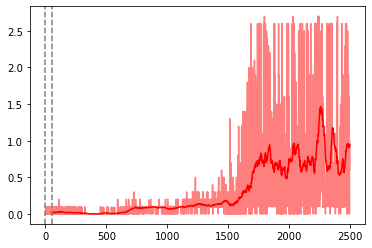

In [14]:
import matplotlib.pyplot as plt

smooth_period = 50
episode_markers = [0,50]
colour='r'

fig, ax = plt.subplots()
ax.plot(score_history,color=colour,alpha=0.5)
ave, inds = moving_average(score_history,smooth_period)
ax.plot(inds,ave,color=colour)
for m in episode_markers:
    ax.axvline(m,color='0.5',ls='--')
plt.show()